# Natural Language Processing with Disaster Tweets

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras_nlp
import keras
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import kagglehub

In [3]:
kagglehub.login()

Kaggle credentials set.
Kaggle credentials successfully validated.


#### Data download and load

In [4]:
NLP_path = kagglehub.competition_download('nlp-getting-started')

100%|██████████| 593k/593k [00:00<00:00, 117MB/s]

Extracting files...


In [5]:
import shutil
import os

display(os.listdir(NLP_path))

['test.csv', 'train.csv', 'sample_submission.csv']

In [31]:
train_file_path = os.path.join(NLP_path, 'train.csv')
test_file_path = os.path.join(NLP_path, 'test.csv')
df_train = pd.read_csv(train_file_path)
df_test = pd.read_csv(test_file_path)

In [65]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [10]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


## Brief description of the problem and data

**Problem Description**:
The goal is to build a model that predicts whether new tweets describe actual emergencies. This helps agencies monitor for real-world incidents on Twitter

**Data Description**:
The training dataset has 7613 rows and 5 columns. The test dataset has 3263 rows and 4 columns. Both datasets have 'id', 'keyword', 'location', and 'text' columns. The training dataset additionally has a 'target' column, which is the label indicating whether a tweet is a disaster tweet (1) or not (0).

## EDA
#### Inspect data


Check for missing values, data types, and unique values in each column.


In [11]:
df_train.info()
print('\nUnique values in each column:')
print(df_train.nunique())
print('\nPercentage of missing values in each column:')
print(df_train.isnull().sum() / len(df_train) * 100)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB

Unique values in each column:
id          7613
keyword      221
location    3341
text        7503
target         2
dtype: int64

Percentage of missing values in each column:
id           0.000000
keyword      0.801261
location    33.272035
text         0.000000
target       0.000000
dtype: float64


#### Visualize data




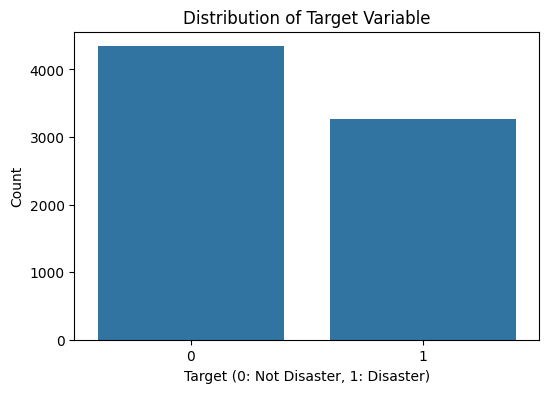

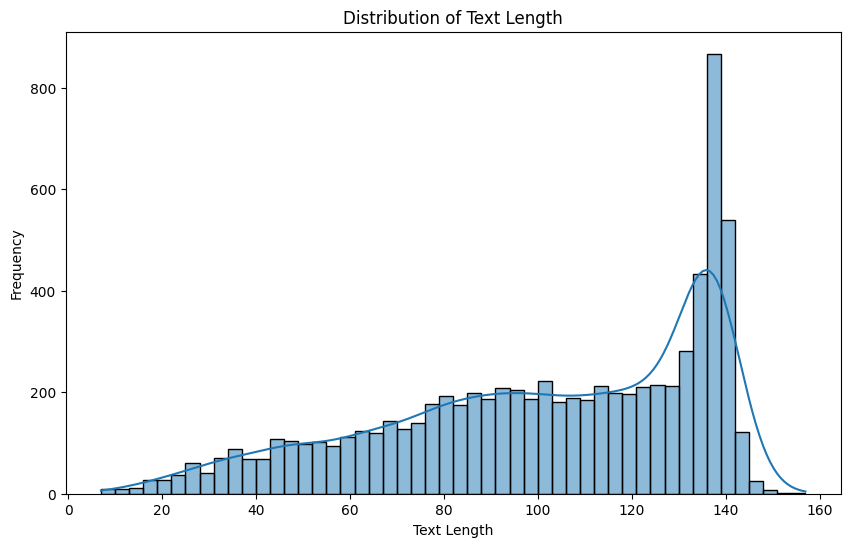

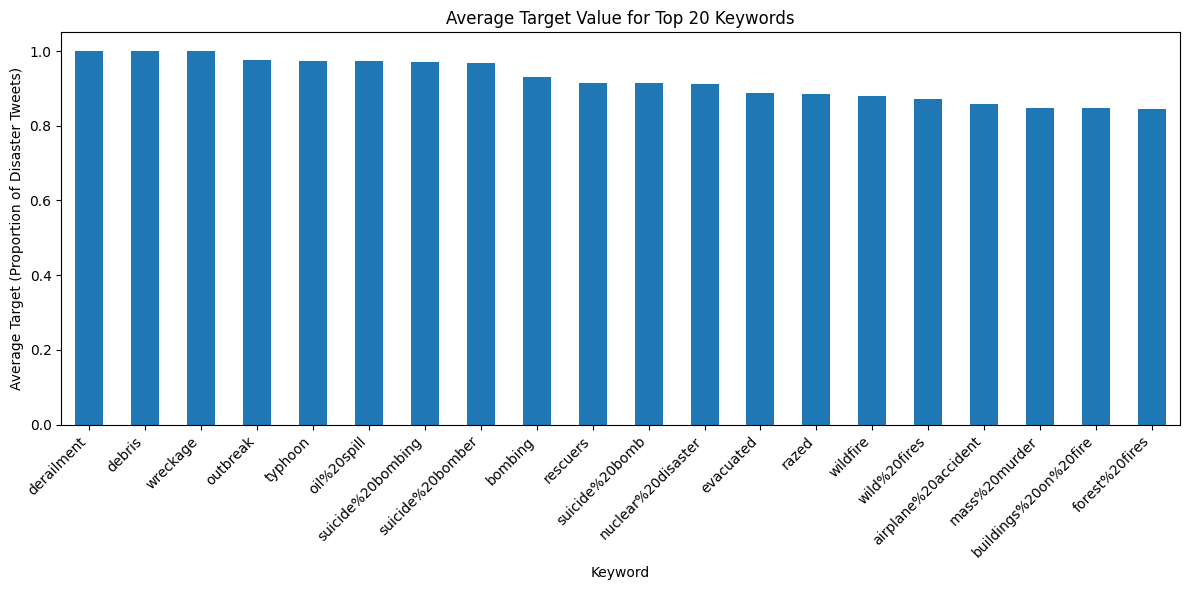

In [12]:
# 1. Plot histogram of the 'target' column
plt.figure(figsize=(6, 4))
sns.countplot(x='target', data=df_train)
plt.title('Distribution of Target Variable')
plt.xlabel('Target (0: Not Disaster, 1: Disaster)')
plt.ylabel('Count')
plt.show()

# 2. Calculate text length
df_train['text_length'] = df_train['text'].apply(len)

# 3. Plot histogram of 'text_length'
plt.figure(figsize=(10, 6))
sns.histplot(df_train['text_length'], bins=50, kde=True)
plt.title('Distribution of Text Length')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

# 4. Plot bar plot of top keywords and their average target
top_n = 20
keyword_target = df_train.groupby('keyword')['target'].mean().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
keyword_target.head(top_n).plot(kind='bar')
plt.title(f'Average Target Value for Top {top_n} Keywords')
plt.xlabel('Keyword')
plt.ylabel('Average Target (Proportion of Disaster Tweets)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Reasoning**:
Fill missing values in 'keyword', drop 'location', and define and apply a text cleaning function to 'text' in both dataframes.



## First Model

#### Model Arch
I choose distil_bert_model as it's pre trained on wiki, so it might have a better understanding on twitter info. It's lightweight, suitable for a baseline model.

In [15]:
from sklearn.model_selection import train_test_split

X = df_train["text"]
y = df_train["target"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_test = df_test["text"]

In [16]:
preset= "distil_bert_base_en_uncased"

# Use a shorter sequence length.
preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(preset,
                                                                   sequence_length=160,
                                                                   name="preprocessor_4_tweets"
                                                                  )

# Pretrained classifier.
classifier = keras_nlp.models.DistilBertClassifier.from_preset(preset,
                                                               preprocessor = preprocessor,
                                                               num_classes=2)

classifier.summary()

100%|██████████| 462/462 [00:00<00:00, 714kB/s]


100%|██████████| 794/794 [00:00<00:00, 1.19MB/s]


100%|██████████| 226k/226k [00:00<00:00, 105MB/s]


100%|██████████| 253M/253M [00:01<00:00, 209MB/s]


Preprocessor: "preprocessor_4_tweets"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ distil_bert_tokenizer (DistilBertTokenizer)                   │                       Vocab size: 30,522 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "distil_bert_text_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ distil_bert_backbone          │ (None, None, 768)         │      66,362,880 │ padding_mask[0][0],        │
│ (DistilBertBackbone)          │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item (GetItem)            │ (None, 768)               │               0 │ distil_bert_backbone[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pooled_dense (Dense)          │ (None, 768)               │         590,592 │ get_item[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ output_dropout (Dropout)      │ (None, 768)               │               0 │ pooled_dense[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logits (Dense)                │ (None, 2)                 │           1,538 │ output_dropout[0][0]       │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 66,955,010 (255.41 MB)

 Trainable params: 66,955,010 (255.41 MB)

 Non-trainable params: 0 (0.00 B)

In [83]:
classifier.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), #'binary_crossentropy',
    optimizer=keras.optimizers.Adam(1e-5),
    metrics= ["accuracy"]
)
BATCH_SIZE = 32
EPOCHS = 2
# Fit
history = classifier.fit(x=X_train,
                         y=y_train,
                         batch_size=BATCH_SIZE,
                         epochs=EPOCHS,
                         validation_data=(X_val, y_val)
                        )

Epoch 1/2
191/191 ━━━━━━━━━━━━━━━━━━━━ 157s 630ms/step - accuracy: 0.8597 - loss: 0.3542 - val_accuracy: 0.8398 - val_loss: 0.3859
Epoch 2/2
191/191 ━━━━━━━━━━━━━━━━━━━━ 100s 523ms/step - accuracy: 0.8870 - loss: 0.3016 - val_accuracy: 0.8365 - val_loss: 0.4048


### First Model Result Evaluation

In [27]:
def evaluate_model(y_true, y_pred):
    """
    Calculates and displays the confusion matrix, precision, recall, and F1 score.

    Args:
        y_true: True labels.
        y_pred: Predicted labels.
    """
    # Calculate the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Display the confusion matrix
    cmd_obj = ConfusionMatrixDisplay(cm, display_labels=['Not Disaster', 'Disaster'])
    cmd_obj.plot()
    plt.title('Confusion Matrix')
    plt.show()


    TN, FP, FN, TP = cm.ravel()

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1_score:.4f}")



48/48 ━━━━━━━━━━━━━━━━━━━━ 11s 194ms/step
Evaluation on Validation Data:


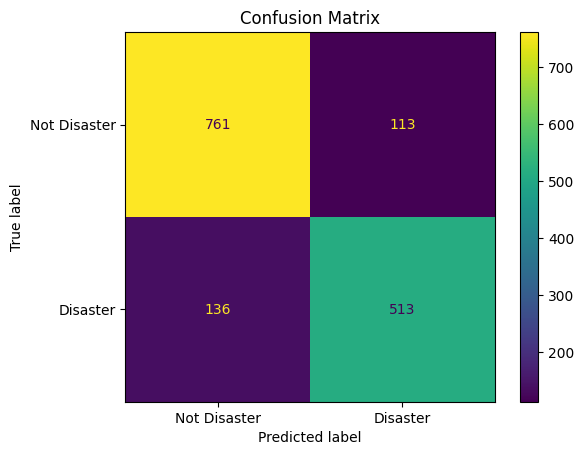

Precision: 0.8195
Recall: 0.7904
F1 Score: 0.8047


In [85]:
# Get predictions on the validation data
y_pred_probs = classifier.predict(X_val)
y_pred = np.argmax(y_pred_probs, axis=1)

# Call the evaluate_model function with validation data
print("Evaluation on Validation Data:")
evaluate_model(y_val, y_pred)

In [86]:
# Make predictions on the test data
test_predictions_probs = classifier.predict(X_test)
test_predictions = np.argmax(test_predictions_probs, axis=1)

# Create the submission DataFrame
submission_df = pd.DataFrame({'id': df_test['id'], 'target': test_predictions})

# Save the submission DataFrame to a CSV file
submission_df.to_csv('submission.csv', index=False)

print("Submission file created successfully!")

102/102 ━━━━━━━━━━━━━━━━━━━━ 17s 165ms/step
Submission file created successfully!


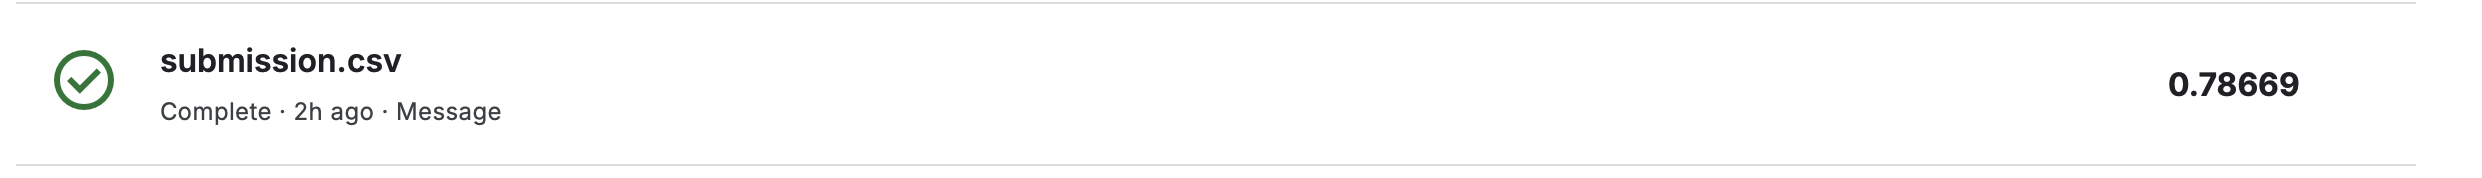

This model only has done 2 epoch. Maybe more epoch can further improve the result

## Hypertuning Model (Second Model)

The second model increases epoch number and add a early stopping callback based on F1 score, as the competition score is calculated by it.

In [25]:
import tensorflow as tf

def f1_score_metric(y_true, y_pred):
    # One-hot encode y_true to match the shape of y_pred
    y_true_one_hot = tf.one_hot(tf.cast(y_true, dtype=tf.int32), depth=tf.shape(y_pred)[-1])

    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true_one_hot * y_pred, 0, 1)))
    possible_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true_one_hot, 0, 1)))
    predicted_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    f1 = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
    return f1

In [32]:
# Pretrained classifier.
classifier2 = keras_nlp.models.DistilBertClassifier.from_preset(preset,
                                                               preprocessor = preprocessor,
                                                               num_classes=2)
classifier2.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(1e-5),
    metrics=['accuracy', f1_score_metric] # Use the custom F1 score metric
)

# Define Early Stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_f1_score_metric', # Monitor validation F1 score
    patience=1,
    restore_best_weights=True, # Restore model weights from the epoch with the best value of the monitored quantity.
    mode='max' # Specify mode as 'max' for F1 score
)

# Increase epochs
EPOCHS = 10

# Fit the model with Early Stopping
history2 = classifier2.fit(x=X_train,
                         y=y_train,
                         batch_size=BATCH_SIZE,
                         epochs=EPOCHS,
                         validation_data=(X_val, y_val),
                         callbacks=[early_stopping] # Add Early Stopping callback
                        )

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 148s 599ms/step - accuracy: 0.7059 - f1_score_metric: 0.2754 - loss: 0.5758 - val_accuracy: 0.8313 - val_f1_score_metric: 0.7876 - val_loss: 0.4039
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 93s 488ms/step - accuracy: 0.8389 - f1_score_metric: 0.7939 - loss: 0.3849 - val_accuracy: 0.8470 - val_f1_score_metric: 0.8055 - val_loss: 0.3871
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 93s 486ms/step - accuracy: 0.8686 - f1_score_metric: 0.8377 - loss: 0.3312 - val_accuracy: 0.8490 - val_f1_score_metric: 0.8125 - val_loss: 0.3890
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 93s 486ms/step - accuracy: 0.8933 - f1_score_metric: 0.8674 - loss: 0.2848 - val_accuracy: 0.8444 - val_f1_score_metric: 0.8158 - val_loss: 0.4045
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 93s 485ms/step - accuracy: 0.9139 - f1_score_metric: 0.8922 - loss: 0.2457 - val_accuracy: 0.8345 - val_f1_score_metric: 0.8108 - val_loss: 0.4416


### Second Model Result Evaluation

48/48 ━━━━━━━━━━━━━━━━━━━━ 12s 200ms/step
Evaluation on Validation Data:


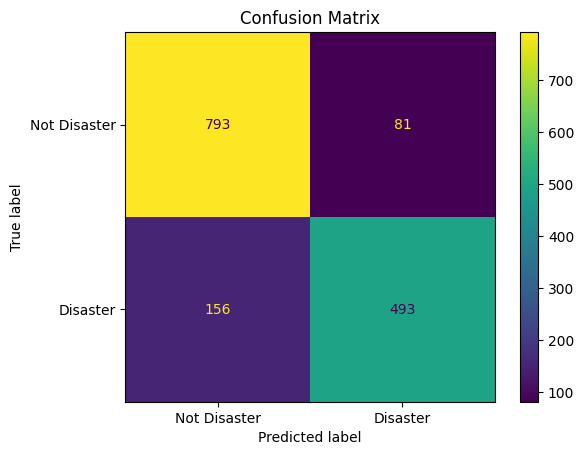

Precision: 0.8589
Recall: 0.7596
F1 Score: 0.8062


In [33]:
# Get predictions on the validation data
y_pred_probs = classifier2.predict(X_val)
y_pred = np.argmax(y_pred_probs, axis=1)

# Call the evaluate_model function with validation data
print("Evaluation on Validation Data:")
evaluate_model(y_val, y_pred)

In [34]:
def plot_training_history(history):
    """
    Plots training and validation F1 score and loss over epochs.

    Args:
        history: The history object returned from model.fit().
    """
    # Plot training and validation F1 score over epochs
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['f1_score_metric'], label='Training F1 Score')
    plt.plot(history.history['val_f1_score_metric'], label='Validation F1 Score')
    plt.title('F1 Score over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot training and validation loss over epochs
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()



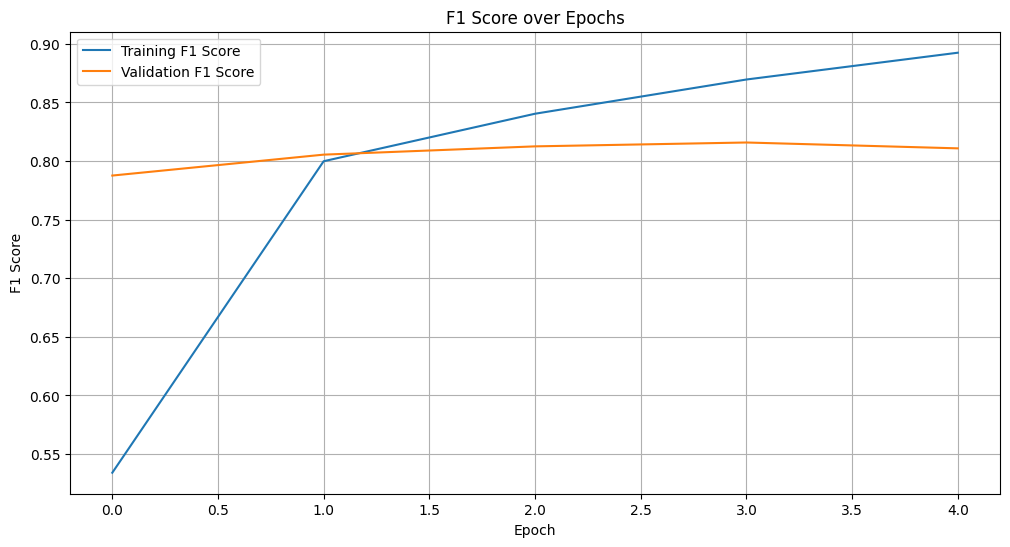

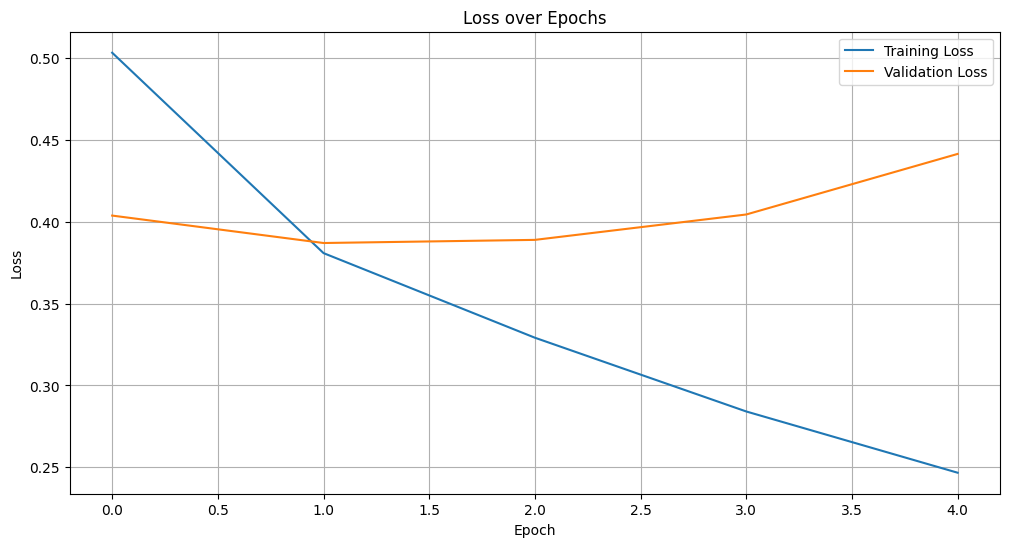

In [35]:
# Call the function with the training history
plot_training_history(history2)

In [36]:
# Make predictions on the test data
test_predictions_probs = classifier2.predict(X_test)
test_predictions = np.argmax(test_predictions_probs, axis=1)

# Create the submission DataFrame
submission_df = pd.DataFrame({'id': df_test['id'], 'target': test_predictions})

# Save the submission DataFrame to a CSV file
submission_df.to_csv('submission2.csv', index=False)

print("Submission file created successfully!")

102/102 ━━━━━━━━━━━━━━━━━━━━ 17s 167ms/step
Submission file created successfully!


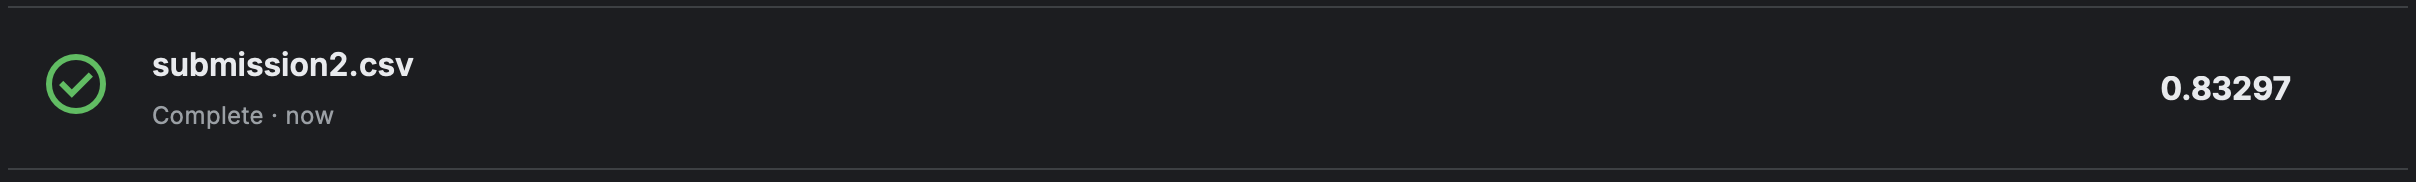

#### Result Reflection
This model provides a better result. More training and early stop call back by F1 works well.

#### Convert Keyboard to Hashtag Topic

**Previous method only utilized text info in training dataset. Preprocessing text is not optimized for twitter. Next I will try to include keyword info to see if any improvement for the result.** Location is exclude due to more than 30% missing value.

In [17]:
df_train = pd.read_csv(train_file_path)
df_test = pd.read_csv(test_file_path)

In [18]:
import numpy as np

def create_full_info(row):
    text = row['text']
    keyword = row['keyword']
    location = row['location']

    full_info = text

    if pd.notna(keyword) and keyword != '':
        full_info += ' #' + str(keyword).replace(' ', '_') # Convert spaces to underscores for keywords

    if pd.notna(location) and location != '':
        full_info += ' #' + str(location).replace(' ', '_') # Convert spaces to underscores for locations

    return full_info

# Apply the function to create the 'full_info' column
df_train['full_info'] = df_train.apply(create_full_info, axis=1)
df_test['full_info'] = df_test.apply(create_full_info, axis=1)


# Display the first few rows of the modified dataframes to verify
display(df_train[['text', 'keyword', 'location', 'full_info']].head())
display(df_test[['text', 'keyword', 'location', 'full_info']].head())

,text,keyword,location,full_info
0,Our Deeds are the Reason of this #earthquake M...,NaN,NaN,Our Deeds are the Reason of this #earthquake M...
1,Forest fire near La Ronge Sask. Canada,NaN,NaN,Forest fire near La Ronge Sask. Canada
2,All residents asked to 'shelter in place' are ...,NaN,NaN,All residents asked to 'shelter in place' are ...
3,"13,000 people receive #wildfires evacuation or...",NaN,NaN,"13,000 people receive #wildfires evacuation or..."
4,Just got sent this photo from Ruby #Alaska as ...,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...


,text,keyword,location,full_info
0,Just happened a terrible car crash,NaN,NaN,Just happened a terrible car crash
1,"Heard about #earthquake is different cities, s...",NaN,NaN,"Heard about #earthquake is different cities, s..."
2,"there is a forest fire at spot pond, geese are...",NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,Apocalypse lighting. #Spokane #wildfires,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,Typhoon Soudelor kills 28 in China and Taiwan,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [19]:
from sklearn.model_selection import train_test_split

X = df_train["full_info"] # Use the new 'full_info' column for training data
y = df_train["target"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_test = df_test["full_info"] # Use the new 'full_info' column for test data

print("Data split complete. Shapes:")
print("X_train:", X_train.shape)
print("X_val:", X_val.shape)
print("y_train:", y_train.shape)
print("y_val:", y_val.shape)
print("X_test:", X_test.shape)

Data split complete. Shapes:
X_train: (6090,)
X_val: (1523,)
y_train: (6090,)
y_val: (1523,)
X_test: (3263,)


In [20]:
import re

def clean_tweet(text):
    text = re.sub(r"http\S+", "", text)

    return text.strip()

In [21]:
# Apply the clean_tweet function to the full_info column in X_train, X_val, and X_test
X_train = X_train.apply(clean_tweet)
X_val = X_val.apply(clean_tweet)
X_test = X_test.apply(clean_tweet)

print("Text cleaning applied to X_train, X_val, and X_test.")

Text cleaning applied to X_train, X_val, and X_test.


In [22]:
X_train

,full_info
4996,Courageous and honest analysis of need to use ...
3263,@ZachZaidman @670TheScore wld b a shame if tha...
4907,Tell @BarackObama to rescind medals of 'honor'...
2855,Worried about how the CA drought might affect ...
4716,@YoungHeroesID Lava Blast &amp; Power Red #Pan...
...,...
5226,@Eganator2000 There aren't many Obliteration s...
5390,just had a panic attack bc I don't have enough...
860,Omron HEM-712C Automatic Blood Pressure Monito...
7603,Officials say a quarantine is in place at an A...


In [23]:
for x in range(50):
  print(X_train.iloc[x])

Courageous and honest analysis of need to use Atomic Bomb in 1945. #Hiroshima70 Japanese military refused surrender.  #military #Texas
@ZachZaidman @670TheScore wld b a shame if that golf cart became engulfed in flames. #boycottBears #engulfed
Tell @BarackObama to rescind medals of 'honor' given to US soldiers at the Massacre of Wounded Knee. SIGN NOW &amp; RT!  #massacre #Cottonwood_Arizona
Worried about how the CA drought might affect you? Extreme Weather: Does it Dampen Our Economy?  #drought #Spokane,_WA
@YoungHeroesID Lava Blast &amp; Power Red #PantherAttack @JamilAzzaini @alifaditha #lava #Medan,Indonesia
Wreckage 'Conclusively Confirmed' as From MH370: Malaysia PM: Investigators and the families of those who were...  #wreckage
Our builder is having a dental emergency. Which has ruined my plan to emotionally blackmail him this afternoon with my bump. #emergency%20plan #Ireland
BMX issues Areal Flood Advisory for Shelby [AL] till Aug 5 9:00 PM CDT  #flood
#360WiseNews : China's S

## Third Model with updated preprocessed text

In [26]:
# Pretrained classifier.
classifier3 = keras_nlp.models.DistilBertClassifier.from_preset(preset,
                                                               preprocessor = preprocessor,
                                                               num_classes=2)
classifier3.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(1e-5),
    metrics=['accuracy', f1_score_metric] # Use the custom F1 score metric
)

# Define Early Stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_f1_score_metric', # Monitor validation F1 score
    patience=1,           # Number of epochs with no improvement after which training will be stopped.
    restore_best_weights=True, # Restore model weights from the epoch with the best value of the monitored quantity.
    mode='max' # Specify mode as 'max' for F1 score
)

# Increase epochs
EPOCHS = 10
BATCH_SIZE= 32
# Fit the model with Early Stopping
history3 = classifier3.fit(x=X_train,
                         y=y_train,
                         batch_size=BATCH_SIZE,
                         epochs=EPOCHS,
                         validation_data=(X_val, y_val),
                         callbacks=[early_stopping] # Add Early Stopping callback
                        )

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 153s 604ms/step - accuracy: 0.7415 - f1_score_metric: 0.3443 - loss: 0.5519 - val_accuracy: 0.8372 - val_f1_score_metric: 0.8004 - val_loss: 0.4037
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 94s 489ms/step - accuracy: 0.8441 - f1_score_metric: 0.8016 - loss: 0.3794 - val_accuracy: 0.8437 - val_f1_score_metric: 0.8026 - val_loss: 0.3884
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 93s 485ms/step - accuracy: 0.8714 - f1_score_metric: 0.8381 - loss: 0.3300 - val_accuracy: 0.8411 - val_f1_score_metric: 0.8083 - val_loss: 0.3969
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 93s 484ms/step - accuracy: 0.8988 - f1_score_metric: 0.8765 - loss: 0.2742 - val_accuracy: 0.8326 - val_f1_score_metric: 0.8079 - val_loss: 0.4242


#### Third Model Result Anlysis

48/48 ━━━━━━━━━━━━━━━━━━━━ 12s 196ms/step
Evaluation on Validation Data:


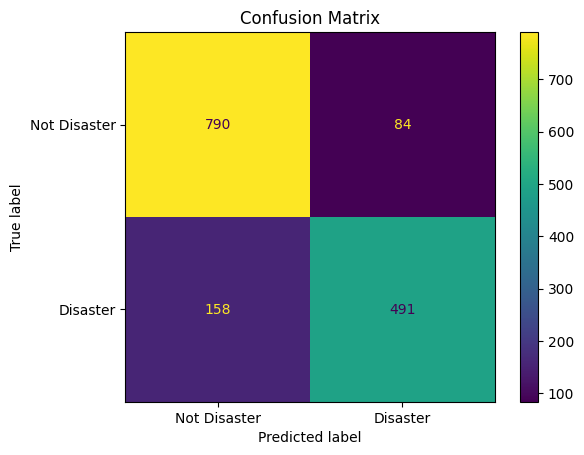

Precision: 0.8539
Recall: 0.7565
F1 Score: 0.8023


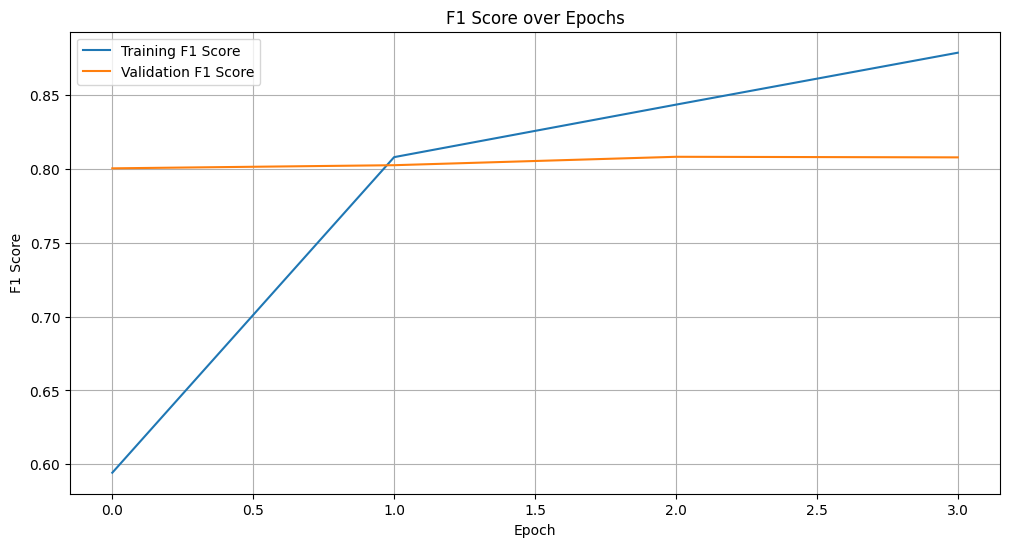

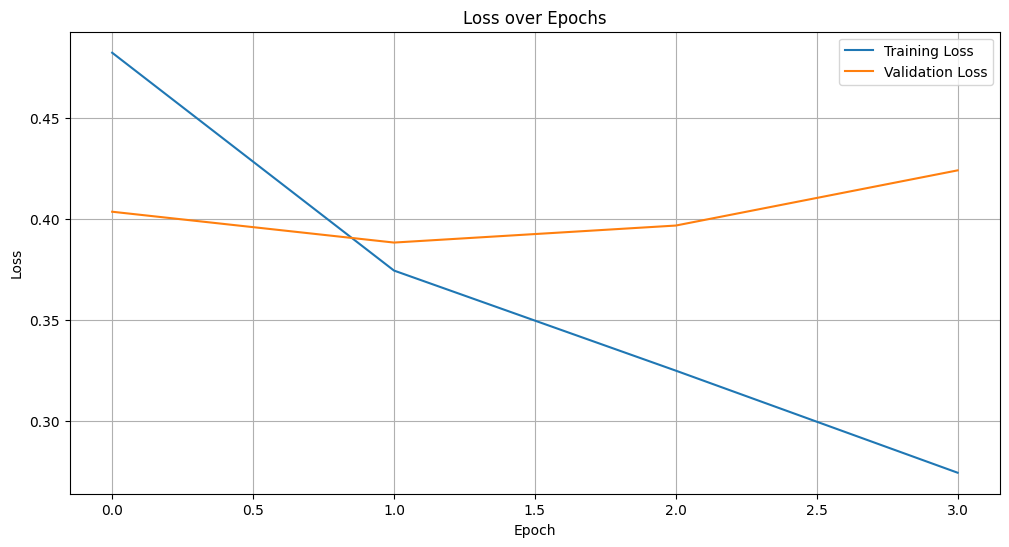

In [29]:
# Get predictions on the validation data
y_pred_probs = classifier3.predict(X_val)
y_pred = np.argmax(y_pred_probs, axis=1)

# Call the evaluate_model function with validation data
print("Evaluation on Validation Data:")
evaluate_model(y_val, y_pred)

# Call the function with the training history
plot_training_history(history3)

In [30]:
# Make predictions on the test data
test_predictions_probs = classifier3.predict(X_test)
test_predictions = np.argmax(test_predictions_probs, axis=1)

# Create the submission DataFrame
submission_df = pd.DataFrame({'id': df_test['id'], 'target': test_predictions})

# Save the submission DataFrame to a CSV file
submission_df.to_csv('submission3.csv', index=False)

print("Submission file created successfully!")

102/102 ━━━━━━━━━━━━━━━━━━━━ 18s 177ms/step
Submission file created successfully!


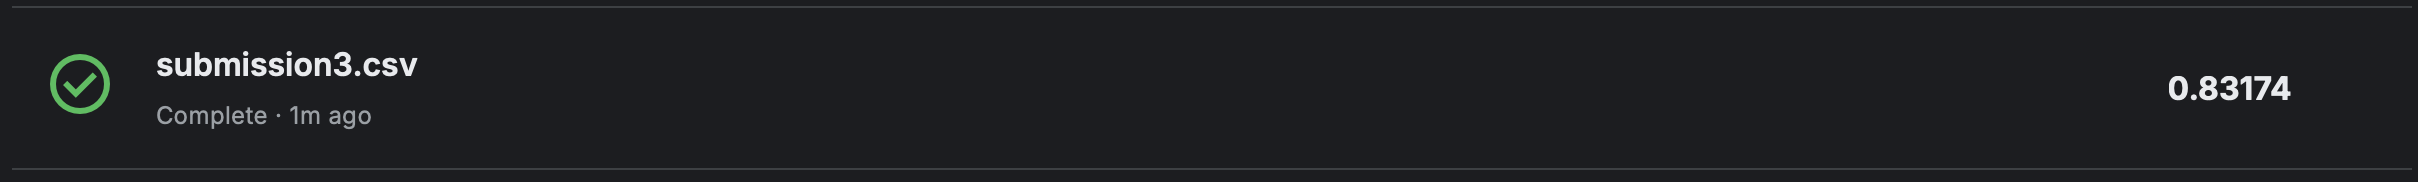

#### Result Reflection
Adding keyword and location as hashtag to the text seems not creating any tangible improvement for prediction. The third model doesn't outperform the second one.
Therefore, the next model will only consider text info.

## Fourth Model using Tweet pretrained model


**I choose `bertweet-base` pretrained model, as its tokenizer is optimized for tweet info which could recognizing hashtag topic info. I expect it will have a deeper understanding than the previous model trained on wikipedia info.**

#### Fourth Model Arch

`bertweet-base` pretrain the transformer model is used. As it's pretrain on twitter, maybe better performance for binary classification on text.

In [37]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig

checkpoint = "vinai/bertweet-base"
config = AutoConfig.from_pretrained(
    checkpoint,
    num_labels=2
)
tokenizer = AutoTokenizer.from_pretrained(checkpoint, use_fast=False)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, config=config)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/558 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

bpe.codes: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [38]:
print(model)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(64001, 768, padding_idx=1)
      (position_embeddings): Embedding(130, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [39]:
df_train = pd.read_csv(train_file_path)
df_test = pd.read_csv(test_file_path)

X = df_train["text"]
y = df_train["target"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_test = df_test["text"]

In [40]:
# Tokenize the training, validation, and test data with a specified max_length
train_encodings = tokenizer(list(X_train), padding=True, )
val_encodings = tokenizer(list(X_val),  padding=True)
test_encodings = tokenizer(list(X_test), padding=True)


In [41]:
from datasets import Dataset

# Create Dataset objects for training, validation, and test sets
train_dataset = Dataset.from_dict(train_encodings).add_column("labels", y_train.tolist())
val_dataset = Dataset.from_dict(val_encodings).add_column("labels", y_val.tolist())
test_dataset = Dataset.from_dict(test_encodings)

print("Hugging Face Datasets created.")
print("Train Dataset:", train_dataset)
print("Validation Dataset:", val_dataset)
print("Test Dataset:", test_dataset)

Hugging Face Datasets created.
Train Dataset: Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
    num_rows: 6090
})
Validation Dataset: Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
    num_rows: 1523
})
Test Dataset: Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 3263
})


In [42]:
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback
import torch

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=100,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    no_cuda=not torch.cuda.is_available(),
    report_to="none"
)

# Move model to GPU if available (optional; Trainer handles it internally too)
if torch.cuda.is_available():
    model.to('cuda')

# Initialize Trainer with early stopping
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=1)]
)

print("Training arguments and Trainer initialized.")

Training arguments and Trainer initialized.


In [43]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [44]:
# Start training
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.367000,0.381832
2,0.315100,0.431766


TrainOutput(global_step=762, training_loss=0.4227759882299293, metrics={'train_runtime': 237.6935, 'train_samples_per_second': 76.864, 'train_steps_per_second': 4.809, 'total_flos': 569584045976400.0, 'train_loss': 0.4227759882299293, 'epoch': 2.0})

#### Result Evaluation

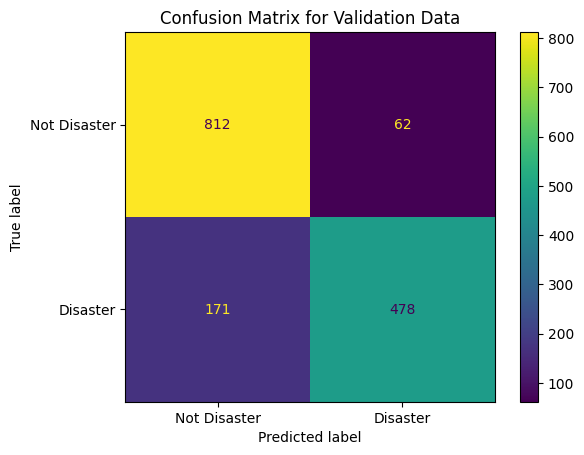

Precision: 0.8852
Recall: 0.7365
F1 Score: 0.8040


In [45]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import numpy as np

# Get predictions on the validation data using the trainer
eval_results = trainer.predict(val_dataset)
y_pred_probs = eval_results.predictions
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = eval_results.label_ids

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
cmd_obj = ConfusionMatrixDisplay(cm, display_labels=['Not Disaster', 'Disaster'])
cmd_obj.plot()
plt.title('Confusion Matrix for Validation Data')
plt.show()

# Calculate and print Precision, Recall, and F1 Score
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

In [46]:
# Make predictions on the test data using the trainer
test_predictions_output = trainer.predict(test_dataset)
test_predictions_probs = test_predictions_output.predictions
test_predictions = np.argmax(test_predictions_probs, axis=1)

# Create the submission DataFrame
# We need the original test dataframe to get the 'id' column
submission_df = pd.DataFrame({'id': df_test['id'], 'target': test_predictions})

# Save the submission DataFrame to a CSV file
submission_df.to_csv('submission4.csv', index=False)

print("Submission file created successfully!")

Submission file created successfully!


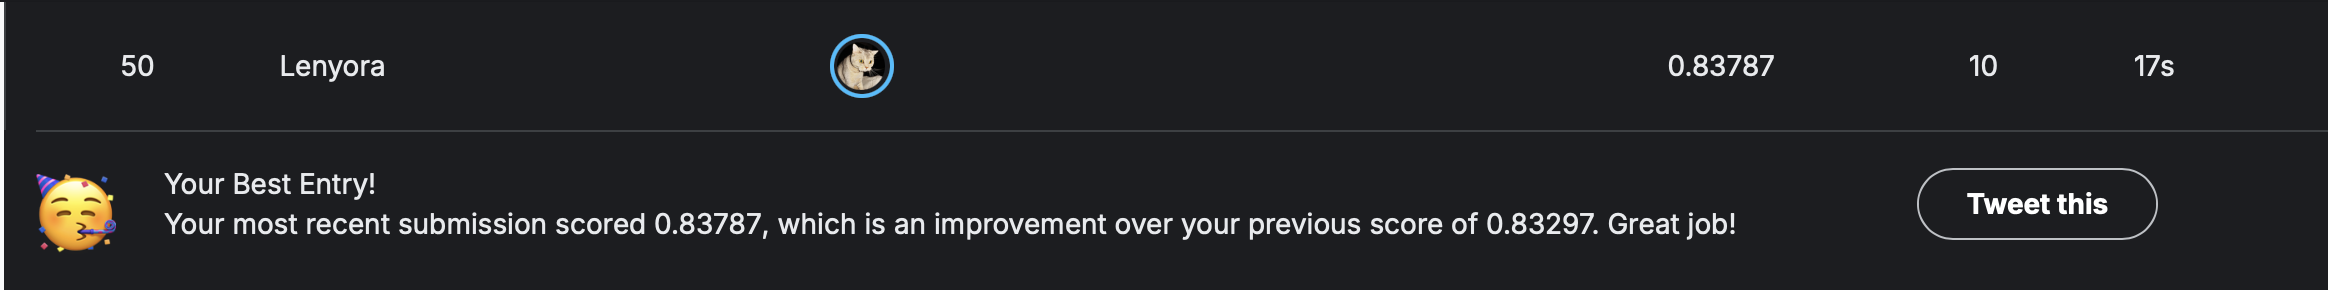

#### Results Reflection
As I expected, 4th model pretrained on tweets performs best, compared with prior model pretrain on wikipedia.

## Conclusion
In this project, I tried 4 models:

  1.  distil_bert_model with 2 epoch
  2.  distil_bert_model with 10 epoch, early stopping callback by F1 score (Hypertuning)
  3.  distil_bert_model with updated text including location and keyword.
  4.  bertweet-base  

Among 4 models, bertweet-base performs best as I expected. It's pretrained on tweets, so it maybe get a better understanding on tweets writing style like hashtag, abbreviation, and even emoji.

Initially, I thought including keyword and location info to text may further improve the performance. However, it didn't show any significant improvement. I can only assume it either adds noise to the text or these info are repetivie info with text itself, adding little value to the model. I also tried to clean the data by removing @, #. It also doesn't work. It's very likely such case has been handled very well in pretrained model.

For future work, I could use a large model pretrained on tweets, which may have a better performance, compared the base version I am using here.

GITHUB LINK [https://github.com/Marcusly17/CU_ML3_WK4](https://github.com/Marcusly17/CU_ML3_WK4)